In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter

In [2]:
raw_data = pd.read_pickle('/Users/hongyuli/Documents/UChi/Winter_2022/FINM33160 ML/Lecture2, 2022/dataset.pkl')

In [3]:
data = raw_data.copy()
data.fillna(0.0,inplace=True)

# Functions to Use

In [4]:
def baggingtree_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [5]:
def baggingtree_feat_importance(m, df):
    feature_importances = []
    for est in m.estimators_:
        fi = est.feature_importances_
        feature_importances.append(fi)
    feature_importances = np.array(feature_importances)
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [6]:
def profit_importance(t,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(20):
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = t.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

# Problem 2

1. Insert a column in the data set with entries: 2 if the stock return is more then 5% higher than the SPY return, 1 if it is more than 1% but less than 5% higher, 0 if it is between -1% and 1%, -2 if the stock underperforms the SPY by more than -5% and -1 if the performance is between -1% and -5%

In [7]:
def f(x):
    if x > .05:
        return 2
    elif .01<x<=.05:
        return 1
    elif -.01<=x<=.01:
        return 0
    elif x<-.05:
        return -2
    else:
        return -1

In [8]:
data['rel_performance'] = data['pred_rel_return'].apply(f)

In [9]:
data['rel_performance']

date        ticker
2000-02-01  LLB      -2
2000-02-03  MYR       2
2000-02-08  LZB       2
            SJM       2
2000-02-09  CSCO     -1
                     ..
2018-12-31  ELLO      0
            MFCB      0
            MFCB      0
            PETZ      0
            SGOC      0
Name: rel_performance, Length: 294412, dtype: int64

In [10]:
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

In [11]:
data.head()

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0,rel_performance
date,,,,,,,,,,,,,,,,,,,,,
2000-02-01,LLB,3.540,0.143,7.668,6.732,2.553,0.458,6.3910,6.391,6.989,...,0,0,0,0,0,0,0,0,0,-2
2000-02-03,MYR,107.661,24.387,220.463,136.555,1.049,36.883,25.5360,22.082,28.458,...,0,0,0,0,0,0,0,0,0,2
2000-02-08,LZB,447.719,57.893,740.905,460.612,16.531,274.525,52.2660,52.274,52.544,...,0,0,0,0,0,0,0,0,0,2
2000-02-08,SJM,234.415,33.821,488.136,322.432,26.054,91.172,28.8808,28.603,32.425,...,0,0,0,0,0,0,0,0,0,2
2000-02-09,CSCO,7722.000,482.000,21391.000,16523.000,3968.000,1422.000,3374.1250,3648.000,3445.000,...,0,0,0,0,0,0,0,0,0,-1


2. Create a BaggingClassifier with a DecisionTreeClassifier with max_level = 6 and n_estimators = 40 and the new column as labels.

3. Use the period 2007-2010 to train the model on the data set constructed above and construct a set of features that optimizes the profit of the long-short strategy on the quarter 2009-07-30 – 2009-10-30


In [12]:
df_1 = data.loc['2007-01-01':'2010-12-31']

In [13]:
df_valid_1 = data.loc['2009-07-30':'2009-10-30']

In [14]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [15]:
valid_1 = df_valid_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [16]:
train_1_stock_returns = df_1['next_period_return']

In [17]:
y_1 = df_1['rel_performance']
y_valid_1 = df_valid_1['rel_performance']
valid_1_stock_returns = df_valid_1['next_period_return']

In [18]:
y_1 = y_1.values
y_valid_1 = y_valid_1.values

In [19]:
t_clf = DecisionTreeClassifier(max_depth=8,min_samples_leaf=800)

In [20]:
bg_clf = BaggingClassifier(t_clf,n_estimators=40,oob_score=True,random_state=123,n_jobs=1)

In [21]:
bg_clf.fit(train_1,y_1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8,
                                                        min_samples_leaf=800),
                  n_estimators=40, n_jobs=1, oob_score=True, random_state=123)

In [22]:
pred_valid = bg_clf.predict(valid_1)

In [23]:
bg_clf.oob_score_

0.43812822164948456

In [24]:
confusion_matrix(y_valid_1,pred_valid)

array([[ 268,    0,    0,    0, 1192],
       [  50,    0,    0,    0,  400],
       [  39,    0,    0,    0,  268],
       [  46,    0,    0,    0,  414],
       [ 113,    0,    0,    0, 1599]])

In [25]:
fi = baggingtree_feat_importance(bg_clf,train_1)

In [26]:
features = fi[(fi['feat_imp'] > 0.02)]
features

,cols,feat_imp
87,prccq,0.122511
105,cf_yield,0.094302
89,bmq,0.090254
55,teqq,0.066545
108,dprq,0.047095
91,book_value_yield,0.040974
76,oancfy,0.034866
180,fqtr_2,0.030895
152,ocf_lctq,0.028945
95,evmq,0.024653


<AxesSubplot:ylabel='cols'>

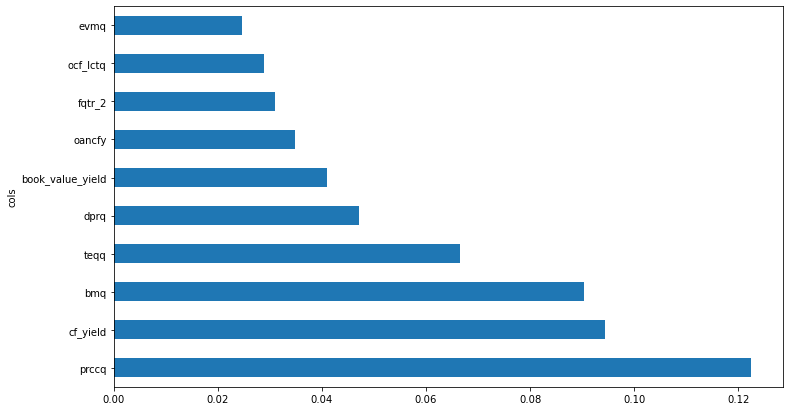

In [27]:
plot_fi(features)

In [28]:
len(features['cols'].values)

10

In [29]:
train_1 = train_1[features['cols'].values]
valid_1 = valid_1[features['cols'].values]

In [30]:
# bg_clf.fit(train_1,y_1)
# bg_clf.score(train_1,y_1)

In [31]:
# pred_valid = bg_clf.predict(valid_1)
# bg_clf.score(valid_1,y_valid_1)

In [32]:
# bg_clf.oob_score_

In [33]:
# (pred_valid * valid_1_stock_returns).sum()

In [34]:
# %time pi = baggingtree_profit_importance(bg_clf,valid_1,df_valid_1['next_period_return'])
# pi

In [35]:
profits = []

feat=[]

train = train_1.copy()
validation = valid_1.copy()

while len(train.columns)>1:
    
    bg_clf.fit(train,y_1)
    pi = baggingtree_profit_importance(bg_clf,validation,y_valid_1)

    col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
    train.drop(col_to_drop,axis=1,inplace=True)
    validation.drop(col_to_drop,axis=1,inplace=True)
    bg_clf.fit(train,y_1)
    
    fi = baggingtree_feat_importance(bg_clf,train)
    features = fi[(fi['feat_imp'] > 0.02)]
    train = train[features['cols'].values]
    validation = validation[features['cols'].values]
    bg_clf.fit(train,y_1)
    
    pred_valid = bg_clf.predict(validation)
    profits.append((pred_valid * df_valid_1['next_period_return']).sum())
    print((pred_valid * df_valid_1['next_period_return']).sum())
    feat.append(features['cols'].values) 

790.3317320000001
797.3690880000001
796.2551760000001
799.088072
730.702948
738.3792360000001
715.537728
679.0744920000001
778.0306679999999


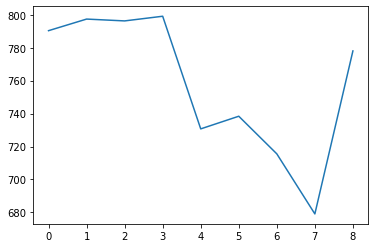

In [36]:
plt.plot(profits);

In [37]:
n = np.argmax(profits)
optim_feats = feat[n]
max_profits = profits[n]

In [38]:
print(max_profits)
print(optim_feats)

799.088072
['prccq' 'book_value_yield' 'cf_yield' 'teqq' 'oancfy' 'ocf_lctq']


4. Backtest the performance of the model with the optimal features over the period 2010 – 2018.

In [39]:
df_test_1 = data.loc['2010-01-01':'2018-12-31']

In [40]:
test_1 = df_test_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [41]:
test_stock_returns = df_test_1['next_period_return']

In [42]:
train_1_optim = train_1[optim_feats]
valid_optim = valid_1[optim_feats]


bg_clf.fit(train_1_optim,y_1)
print(bg_clf.score(train_1_optim,y_1))
pred_valid_tree = bg_clf.predict(valid_optim)
print(bg_clf.score(valid_optim,y_valid_1))
(pred_valid_tree * df_valid_1['next_period_return']).sum()

0.43374677835051545
0.41171109592162225


799.088072

In [43]:
train_1_tree = train_1[optim_feats]
test_tree = test_1[optim_feats]
bg_clf.fit(train_1_tree,y_1)
pred_test_tree = bg_clf.predict(test_tree)
(pred_test_tree * test_stock_returns).sum()

8463.868868

In [44]:
from scipy.cluster import hierarchy as hc
import scipy.stats

In [45]:
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(63)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [46]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [47]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [48]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [49]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [50]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [51]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
        bg_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = bg_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

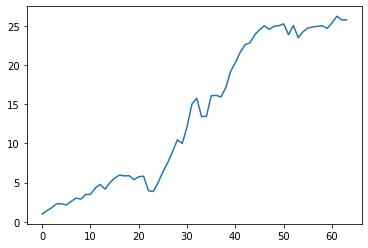

In [52]:
plt.plot(x);

5. Compute Sharpe Ratio, Information Ratio and alpha for the strategy and for the buy-and-hold strategy for SPY

In [53]:
SPY = pd.read_pickle('/Users/hongyuli/Documents/UChi/Winter_2022/FINM33160 ML/Lecture2, 2022/SPY_cum_ret.pkl')
SPY = SPY.loc['2003-01-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

<AxesSubplot:xlabel='date'>

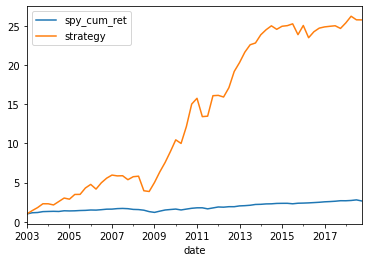

In [54]:
SPY.plot()

In [55]:
SPY = SPY.resample('Y').ffill()

<AxesSubplot:xlabel='date'>

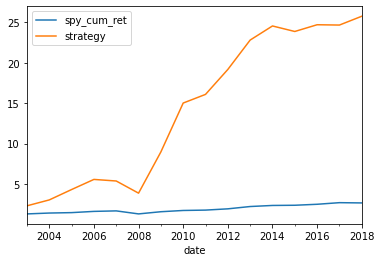

In [56]:
SPY.plot()

In [57]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.7474886717029272


In [58]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SPY Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SPY Sharpe Ratio:  0.5846194645603066


In [59]:
x[-1]

25.761615954318636

In [60]:
SPY['spy_cum_ret'][-1]

2.652199999999999

In [61]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

9.3082215545488

In [62]:
beta_spy = (np.cov(spy_ret,spy_ret)/np.var(spy_ret))[1,0]
beta_spy

1.0714285714285712

In [63]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
print('Strategy Info Ratio:',IR)

Strategy Info Ratio: 0.46478963567183257


In [64]:
residual_ret_spy = spy_ret - beta_spy * spy_ret
IR_spy = np.mean(residual_ret_spy)/np.std(residual_ret_spy)
print('SPY Info Ratio:',IR)

SPY Info Ratio: 0.46478963567183257


In [65]:
alpha = np.mean(residual_ret)
print('Strategy alpha:',alpha)

Strategy alpha: 0.7203857006138108


In [66]:
alpha_spy = np.mean(residual_ret_spy)
print('SPY alpha:',alpha_spy)

SPY alpha: -0.006477147619047591


6. Change hyper parameters for the BaggingClassifier and the DecisionTree and try at least 3 combinations of max_depth and n_estimators. Find optimal features and backtest with each of the combinations of hyperparameters.